In [1]:
import re
import requests

from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import special

mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Helper function for log-normal distribution
def log_normal_pdf(x, m, s):
    return 1 / (x * np.sqrt(s * 2 * np.pi)) * \
        np.exp(-np.square(np.log(x)- m) / (2 * s))

Testing, testing. One, two, three. Can everyone hear me alright?

Wonderful. Hello and welcome to the Warwick Data Science Society Research Blog. It's so nice to see you.

## Introduction

### Testing and Tediosity

Testing is boring. Everyone knows that they _should_ test the solutions they produce, yet reality often fails to live up to this ideal. We check a few obvious things, run through the logic in our head, and convince ourselves that nothing could ever go wrong...and then it does just that.

Sometimes this is okay. For small, individual projects, it's not the end of the world if your code base comes collapsing down on you; a few hours of bodging and everything should be stable again (all be it with code now so messy that you'd want to consider cryongenics). For larger projects, and especially those of collaborative nature, this just won't do.

That is a long way to say, this post is a test, but hopefully not a boring one. To ensure that the testing of this site is performed thoroughly, I decided to write this post to ensure that everything is behaving as expected. I hope it can also act as a template for other keen researchers—whether they are currently a member of WDSS or merely interested in getting involved—to contribute their own work. 

The philosophy of this post is to write about a topic that is actually (well, hopefully) of some interest to people, and do so in a natural way. None of this testing through enumerating corner-cases; let's use the site for what it's made for in practice and share some interesting insights along the way.

With that in mind, I wish to introduce to you: Gibrat's law. Don't be disheartened if you haven't come across this term before,—most haven't. This is likely because the rule is overshadowed by it's far more infamous twin, the central limit theorem. If you've not come across this second term either, don't fret. You may want to watch [this short video](https://www.youtube.com/watch?v=JNm3M9cqWyc) by [Khan Academy](https://www.khanacademy.org/) as a preliminary, but we'll introduce both of these ideas either way.

## Background

### The Central Limit Theorem

We'll start with the central limit theorem. There are many ways of explaining or defining this phenomenon, each striking a subtle balance between statistical rigor and clarity of explanation. We will favor the latter, ensuring to remember that we should keep it too ourselves if we wish to avoid the disapproving gaze of the pure probability theorists.

This simplified description goes as follows: 
- Consider a sequence of independent random variables
- Take the sum of these values
- Regardless of whether the original variables were normally distributed, the distribution of this sum will tend towards a [normal distribution](https://www.mathsisfun.com/data/standard-normal-distribution.html) as the number of variables increases

To clarify this notion, let's look an example. One of the simplest would be an experiment involving tossing multiple fair coins. We consider each coin flip to be an independent random variable taking value zero if the result is tails, and likewise one for heads. We can then say that the total number of heads is the sum of these random variables. It would follow from the central limit theorem that the total number of heads should therefore tend to a normal distribution as the number of total coin tosses gets large. Let's simulate this experiment for different numbers of coins and see this process in action.

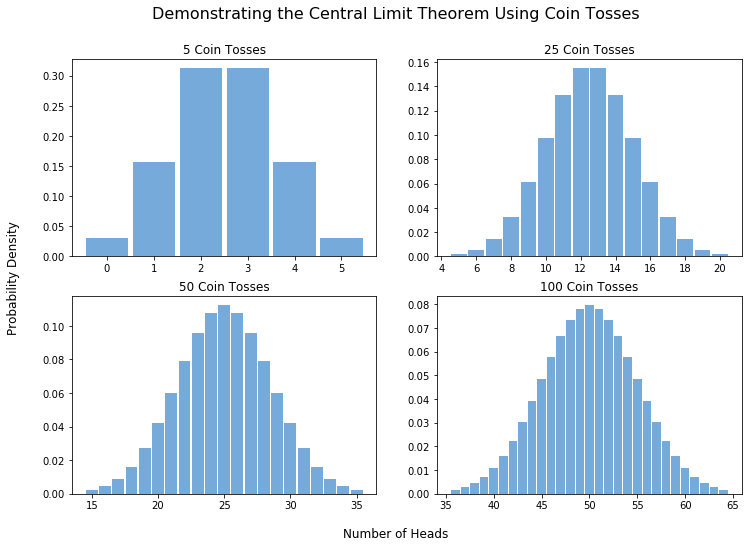

In [3]:
# Okay, I lied, there's actually no simulation going on here
# As the number of simulations approached infinity though the
# simulations would match the analytic solutions so let's not fret

num_coins = [5, 25, 50, 100]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.text(0.5, 0.05, "Number of Heads",
         ha='center', fontsize=12)
fig.text(0.05, 0.5, "Probability Density",
         va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.95, "Demonstrating the Central Limit Theorem Using Coin Tosses",
         ha='center', fontsize=16)

for i, n in enumerate(num_coins):
    ax = axs[i // 2, i % 2]
    x = np.arange(0, n + 1)
    y = np.array([special.binom(n, k) for k in x]) / (2 ** n)
    rm_idxs = np.where(y < 10e-4)  # Remove bars where density is small
    x, y = np.delete(x, rm_idxs), np.delete(y, rm_idxs)
    ax.bar(x, y, color='#75AADB', width=0.9)
    ax.set_title(f"{n} Coin Tosses")

Just as we expected, the more coins we toss, the closer the resulting distribution of heads resembles the classic bell shape of the normal distribution. Indeed, once we use around one hundred or more tosses, we can almost model the number of heads as a continuous variable.

### The Importance of the CLT

It's all well and good that the theory works, but why should we care?

The real power of the central limit theorem presents itself when we want to perform statistical analysis or tests on unfriendly distributions. The normal distribution has some incredibly delightful properties and has been studied in great extent, so working with it is often straightforward. On the other hand, there are many distributions which are not so cooperative, and that's even assuming we know the distribution of whatever we are trying to model. Thankfully, the central limit theorem allows us to circumvent these issues by assuring us that as long as our process can be modeled as the sum of independent random variables (which is a surprisingly common property), we can approximate its distribution as normal and apply all of the standard techniques we know and love.

For example, the number of visitors to a website in a given time period is unlikely to have an underlying normal distribution governing the process. This could make it difficult to analyze data related to this, however the central limit theorem offers a workaround. The rough conceptual notion behind this approach is to divide our time period up into smaller and smaller intervals and consider how many people visit the website in each of those. We can assume that these are reasonably independent and so our total visitor count becomes the sum of many independent random variables and so the central limit theorem holds. A small caveat of this specific result is that we require the number of visitors to the site in the time period to be reasonably large (>20 visitors is typically fine), but as long as this holds, we can perform analysis just as if our data was normally distributed.

## From Sums to Products

This leads us nicely onto Gibrat's law. In our rough definition of the central limit theorem above, we described taking numerous independent random variables and computing their sum. Gibrat's law begins in a similar vein but goes on to consider the product of these values instead. Because of this alteration, we can no longer expect the aggregation to approach a normal distribution as the number of variables grows large. Instead we tend towards a related distribution—the log-normal distribution.

As the name eludes to, a random variable following log-normal distribution can be defined by its logarithm being normally distributed. The converse of this framing is that whenever we take a normal random variable and take its exponential, the result will follow a log-normal distribution. Because of this, a log-normal random variable only takes strictly positive values with a density curve along the lines of the following.

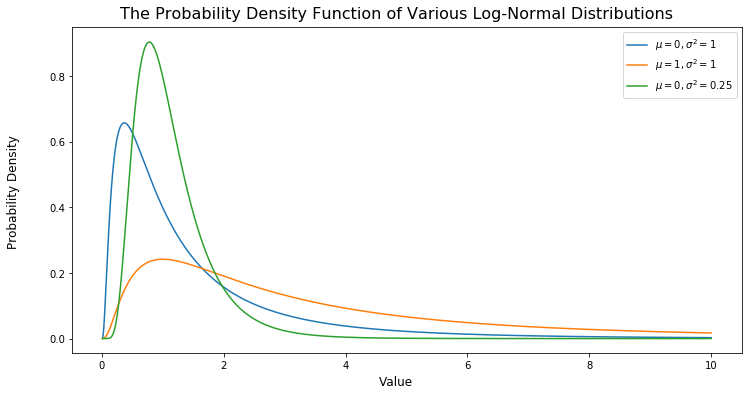

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.text(0.5, 0.05, "Value",
         ha='center', fontsize=12)
fig.text(0.05, 0.5, "Probability Density",
         va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.9, "The Probability Density Function of "
         "Various Log-Normal Distributions",
         ha='center', fontsize=16)

mu = (0, 1, 0)
s2 = (1, 1, 0.25)

x = np.logspace(np.log(0.01), np.log(10), 1000, base=np.e)

for m, s in zip(mu, s2):
    y = log_normal_pdf(x, m, s)
    ax.plot(x, y, label=f"$\mu={m}, \sigma^2={s}$")
ax.legend();

Just as with our coin-tossing experiment for the central limit theorem, we can validate our belief in Gibrat's law using another simulation. We'll introduce an explicit example of Gibrat's law in the final section of the post and for now look an a more esoteric example. In particular, we will consider numerous independent random variables, uniformly-distributed on the interval $(0.5, 1)$. We then take the product of the first $n$ these variables and look at the probability distribution of this value. Using Gibrat's law we would expect this product to approach a log-normal as $n$ becomes large, with a density tending in shape towards the curves shown above. A few simulations shows exactly that.

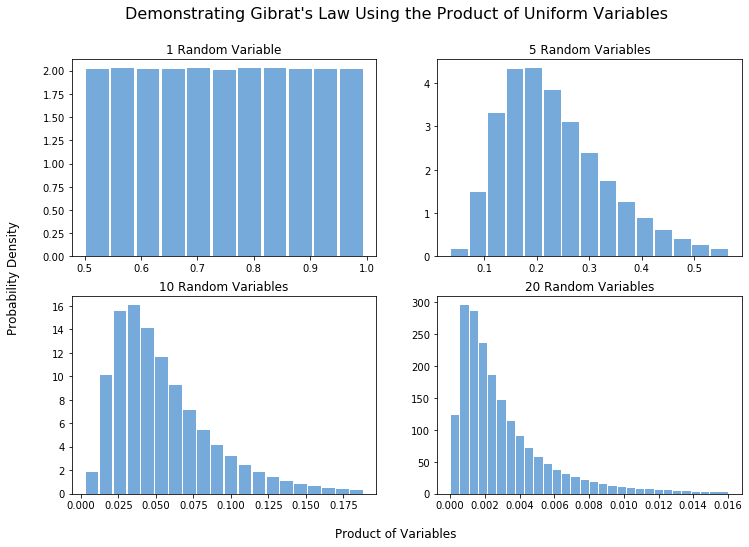

In [5]:
# We'll actually do some simulation this time

num_vars = [1, 5, 10, 20]
num_sims = 10 ** 6

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.text(0.5, 0.05, "Product of Variables",
         ha='center', fontsize=12)
fig.text(0.05, 0.5, "Probability Density",
         va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.95, "Demonstrating Gibrat's Law Using the Product of Uniform Variables",
         ha='center', fontsize=16)

sims = np.random.uniform(0.5, 1, size=(max(num_vars), num_sims))

for i, n in enumerate(num_vars):
    ax = axs[i // 2, i % 2]
    prod = np.prod(sims[:n], axis=0)
    prod = prod[np.where(prod < np.quantile(prod, 0.99))]
    ax.hist(prod, color='#75AADB', density=True,
            bins = max(10, n + 10), rwidth = 0.9)
    ax.set_title(f"{n} Random Variable{'s' if n > 1 else ''}")

It is worth noting that just as there is no one normal distribution, but rather many of various shapes and sizes, parameterized by their mean ($\mu$) and variance ($\sigma^2$), the same is true for the log-normal distribution. In fact, we parameterize a log-normal distribution not by its own mean and variance, but by the mean and variance of the resulting normal distribution we obtain when taking logarithms.

This relationship between the two distributions offers us much of the same power the central limit theorem displays for Gibrat's law too. Yes, taking the product of the independent random variables in its definition doesn't give us the normal distribution we so desire directly, but with a simple logarithmic transformation we can get there. Further, because taking the logarithm of a random variable is a simple transformation with some desirable properties, we are able to utilize many of the tools we have developed for manipulating and analyzing the normal distribution with log-normal distribution. This in turn makes Gibrat's law an incredibly powerful tool for simplifying statistical analysis. One question remains though: when does it hold? What sort of scenarios can be modeled as a product of independent random variables? This brings us neatly to the final section of this post in which we will look into just that, and confirm Gibrat's law in action.

## Verifying the Law

So far we've discussed some interesting ideas, but I think it's time to pull things back from the land of statistical theory into the real world. Where would we expect to find Gibrat's law in our lives?

The key insight needed to answer this question is to understand the underlying mechanism of Gibrat's law; it's all above the multiplication of random variables. Specifically, we take the previous product and multiply it by some new random amount. Another way of looking at this is that these random variables represent the growth rate of some quantity. Now, this is not a fixed growth rate as you would have say with interest rates or nuclear decay, but rather a stochastic growth rate.

To simplify this notion, all we are looking for is systems that evolve by a growth rate proportional to their current size with some added variation captured by the random nature of the variables. An example of such a system (and incidentally the original inspiration for the law) is that of modeling the growth of a firm. In a simple model, we can ignore the impacts of overarching market changes and catastrophic economic events and instead suggest that the growth of a company is roughly proportional to its current size with some added noise. Obviously, this model is primitive and its assumptions do not hold exactly, but it is close enough to believe that the distribution of the size of firms would indeed be log-normally distributed.

Another example could be the distribution of the population sizes for various countries or cities. There are clear troubles with modeling such a system using Gibrat's law, but overall it is not unreasonable to suggest that the population growth of a city is largely dependent on its current size, with some added stochasticity. Don't take my word for it though! Instead, let's quickly gather some data to verify this result for ourselves.

### Sourcing Data

After some searching, I decided that the best data source to investigate the validity of Gibrat's law for use with population data is [this Wikipedia article](https://en.wikipedia.org/wiki/List_of_cities_in_the_United_Kingdom) containing the populations of all sovereign states and dependencies. I then scraped relevant columns from the main table of this page, resulting in a dataset for which ten randomly chosen rows are shown below.

In [6]:
# Scrape table
article = requests.get("https://en.wikipedia.org/wiki/"
                       "List_of_cities_in_the_United_Kingdom")
soup = BeautifulSoup(article.content, 'html.parser')
table = soup.find_all('table', class_='sortable')[0]

# Convert to Pandas dataframe
l = []
for tr in table.find('tbody').find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue
    row = [td.findChild().text for i, td in enumerate(tds) if i in (0, 6)]
    l.append(row)
city_pop_df = pd.DataFrame(l, columns=['City', 'Population'])

# Clean city column
city_pop_df['City'] = city_pop_df['City'].str.extract(r'^([^\d\n]+)')

# Clean population column
city_pop_df['Population'] = city_pop_df['Population'].str.extract(r'^([\d,]+)')
city_pop_df['Population'] = city_pop_df['Population'].str.replace(',', '')
city_pop_df['Population'] = pd.to_numeric(city_pop_df['Population'])

# Sort by population
city_pop_df.sort_values(by='Population', ascending=False, 
                        inplace=True, ignore_index=True)

# Print ten random rows
np.random.seed(1729)
idxs = np.sort(np.random.choice(city_pop_df.shape[0], 10, replace=False))
display(city_pop_df.iloc[idxs])

,City,Population
5,Manchester,503127
24,Southampton,236882
28,York,198051
31,Chelmsford,168310
32,Dundee,153990
51,Bath,88859
53,Hereford,58896
56,Stirling,34790
57,Lichfield,32219
66,City of London,7375


### Visualizing the Results

We can now plot a histogram of the populations for these cities. On top of this, we overlay a log-normal distribution with parameters chosen to best fit (using maximum likelihood estimation) to see how well the densities match.

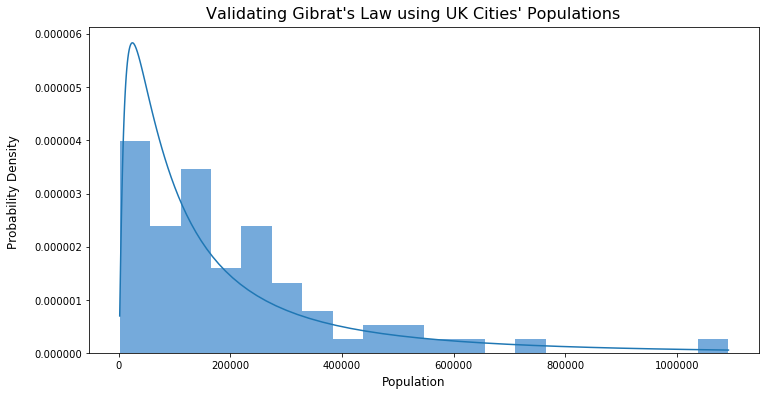

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.text(0.5, 0.05, "Population",
         ha='center', fontsize=12)
fig.text(0.03, 0.5, "Probability Density",
         va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.9, "Validating Gibrat's Law using UK Cities' Populations",
         ha='center', fontsize=16)

ax.hist(city_pop_df['Population'], color='#75AADB', density=True, bins=20)

# Maximum likelihood estimation
m_mle = city_pop_df['Population'].apply(np.log).mean()
s_mle = (city_pop_df['Population'].apply(np.log) - m_mle).pow(2).mean()

x = np.logspace(np.log(city_pop_df['Population'].min()), np.log(city_pop_df['Population'].max()),
                100, base=np.e)

y = log_normal_pdf(x, m_mle, s_mle)
ax.plot(x, y);

Now, before you say anything, I know. It's not perfect. But, I hope we can agree that there is definitely _something_ there. It's also quite easy to explain why the match isn't exact. For a start, we only had data for 69 cities so it's no surprise that the histogram is so jagged. On top of this, city populations is one of the more difficult applications of Gibrat's law due to the many factors that influence their size that aim to violate the assumptions of the rule.

Despite these shortcomings, it is clear that Gibrat's law has value to it either as a conceptual or statistical tool. It should certainly be the case that the validity of the law in any particular scenario should be tested thoroughly before resting too heavy on the results, but as a tool to guide you in the right direction, it is is invaluable.

As eluded to above, the example of population data is more difficult than most applications of Gibrat's law due to the numerous and influential externalities. I didn't want to shy away from this case, especially when it is an example that has clear real-world implications for modeling. It therefore follows that in many more simplistic and controlled cases, Gibrat's law shines even brighter. For example, it has been of great benefit in my work at AstraZeneca in forming suitable priors for energy distributions in statistical models. Without knowledge of this law it may have taken me more time to discover that the log-normal distribution was a natural and accurate model for these quanta.

If anything, this post does not offer anything of immediate practical use. That is not to say however that there isn't an important message. That is, remember Gibrat's law—it's there more than you think, and your awareness of it is vital for optimum efficiency in your statistical work. I hope you found this post of some insight, and I look forward to sharing more ideas and research as this blog developments.